In [230]:
from __future__ import print_function, division

import os
import fnmatch
from time import time

import numpy as np
import scipy as sp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from IPython.display import display

import matplotlib.pyplot as plt
plt.ion()
# set random seed for reproducibility
np.random.seed(31)

VERBOSE = 1

In [231]:
def report_to_table(report):
    """
    Convert classification report in 
    string form to a 2 dimensional array.
    """
    report = report.splitlines()
    res = []
    res.append(['']+report[0].split())
    for row in report[2:-2]:
       res.append(row.split())
    lr = report[-1].split()
    res.append([' '.join(lr[:3])]+lr[3:])
    return np.array(res)

In [276]:
# read image data and save as vectors
DATA_PATH = 'data/CroppedYale'
file_format = '*.pgm'

img_width, img_height = 168, 192
image_dimension = img_height*img_width
n_samples = 2424

image_vectors = np.empty(shape=(n_samples, image_dimension), dtype='float32')
labels = np.empty(shape=(n_samples, 1), dtype='U10')

print('Reading image data from:', DATA_PATH)
t0 = time()
index = 0
for dirpath, dirs, files in os.walk(DATA_PATH):
    for file_name in fnmatch.filter(files, file_format):
        image_path = os.path.join(dirpath, file_name)
        # read image from file
        image = sp.misc.imread(image_path, flatten=True)
        # flatten image
        image_vector = image.ravel()
        # check that image has the right dimensions
        if image_vector.shape[0] == image_dimension:
            # save image vector
            image_vectors[index, :] = image_vector
            
            # use directory name as label for sample
            labels[index, :] = os.path.basename(dirpath)
            
            index += 1
        else:
            if VERBOSE >= 2:
                print('Wrong dimensions:', image_path)

                
# store unique class names
class_names = np.sort(np.unique(labels))
n_classes = class_names.shape[0]

print(index, 'images read')
print(n_classes, 'unique labels')
print('done in %0.3fs' % (time() - t0))

Reading image data from: data/CroppedYale


C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


2424 images read
38 unique labels
done in 1.060s


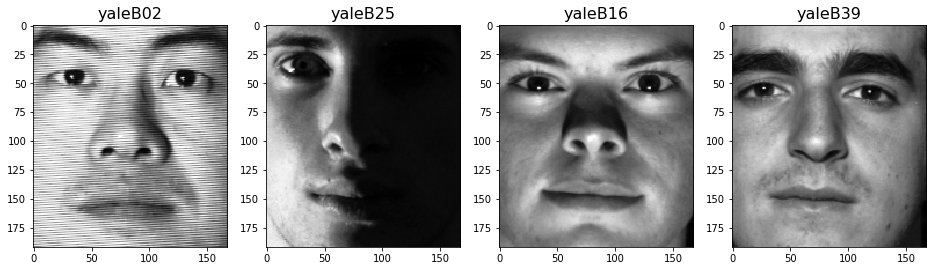

In [277]:
# plot random sample of images from the data set
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 5))
# choose random indices uniformly
random_index = np.random.choice(np.arange(n_samples), size=(4), replace=False)

for col, index in enumerate(random_index):
    ax[col].set_title(labels[index][0], fontsize=16)
    # reshape image to original dimensions
    image = image_vectors[index, :].reshape(img_height, img_width)
    # plot image
    ax[col].imshow(image, cmap=plt.cm.Greys_r)

plt.savefig('report/image_sample.png', bbox_inches='tight')
plt.show()

In [235]:
lda2 = LinearDiscriminantAnalysis(n_components=2)
X_d2 = lda2.fit_transform(X, y)

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


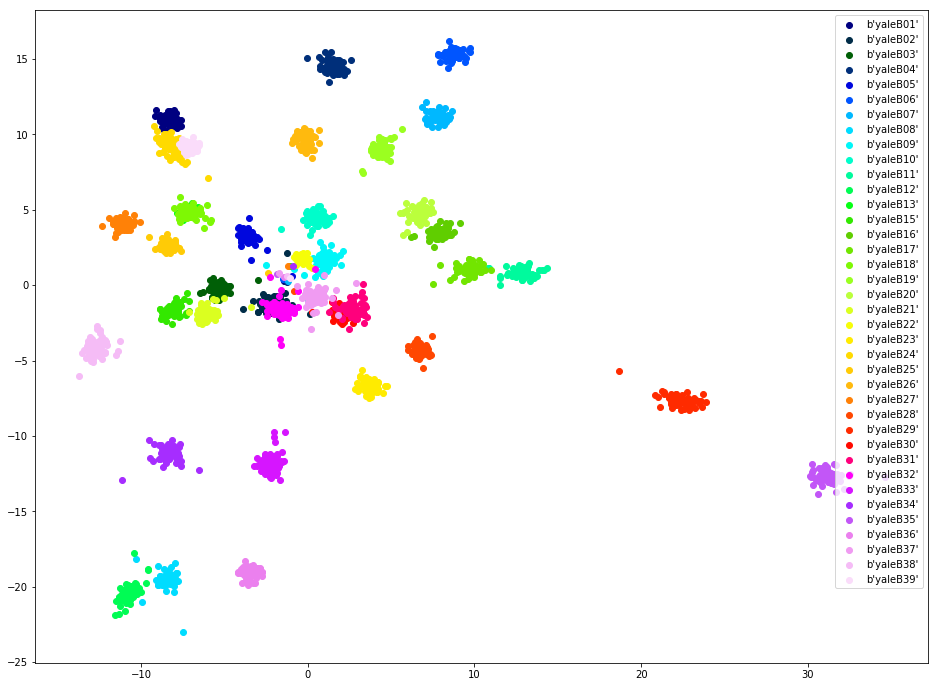

In [238]:
fig, ax = plt.subplots(figsize=(16, 12))

cm = plt.get_cmap('gist_ncar')
ax.set_prop_cycle('color', [cm(1.*i/n_classes) for i in range(n_classes)])

for cls in range(n_classes):
    member_index = np.argwhere(y == cls)
    xs, ys = X_d2[member_index, :].T
    ax.scatter(xs, ys, label='{}'.format(encoder.inverse_transform(cls)))

plt.legend()
plt.show()

In [197]:
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X, y, scoring='f1_macro', cv=10, n_jobs=-1, verbose=10)

print(scores)
print('mean score: {} (+/- {})'.format(scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  3.6min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.6min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min finished


[0.98 1.   0.99 0.98 0.87 0.96 1.   1.   1.   0.84]
mean score: 0.9627144507068106 (+/- 0.05419186308926055)


In [180]:
y_pred = cross_val_predict(lda, X, y, cv=10, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  3.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.6min finished


In [185]:
f1_score(y, y_pred, average='macro')

0.961713946268502

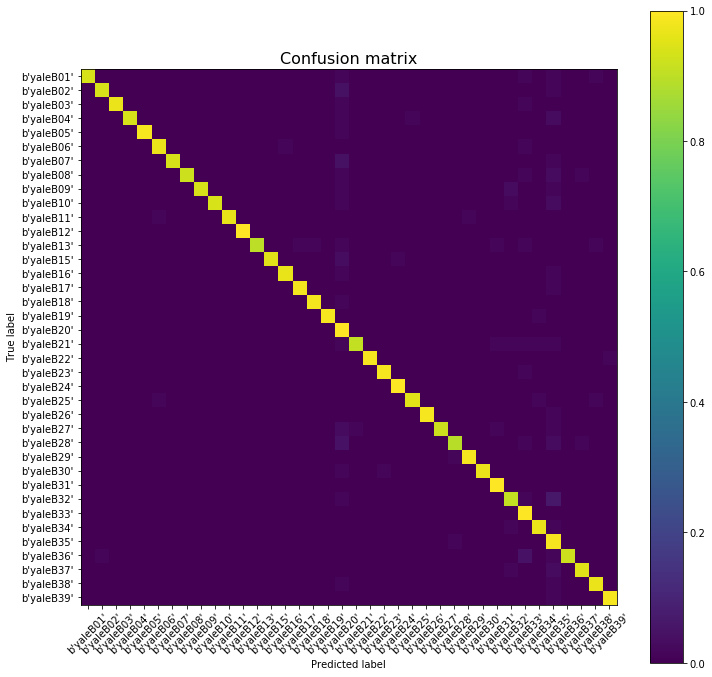

In [182]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(cnf_matrix, interpolation='nearest')
ax.set_title('Confusion matrix', fontsize=16)
fig.colorbar(cax)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(class_names)

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

plt.savefig('report/confusion_matrix.png', bbox_inches='tight')
plt.show()

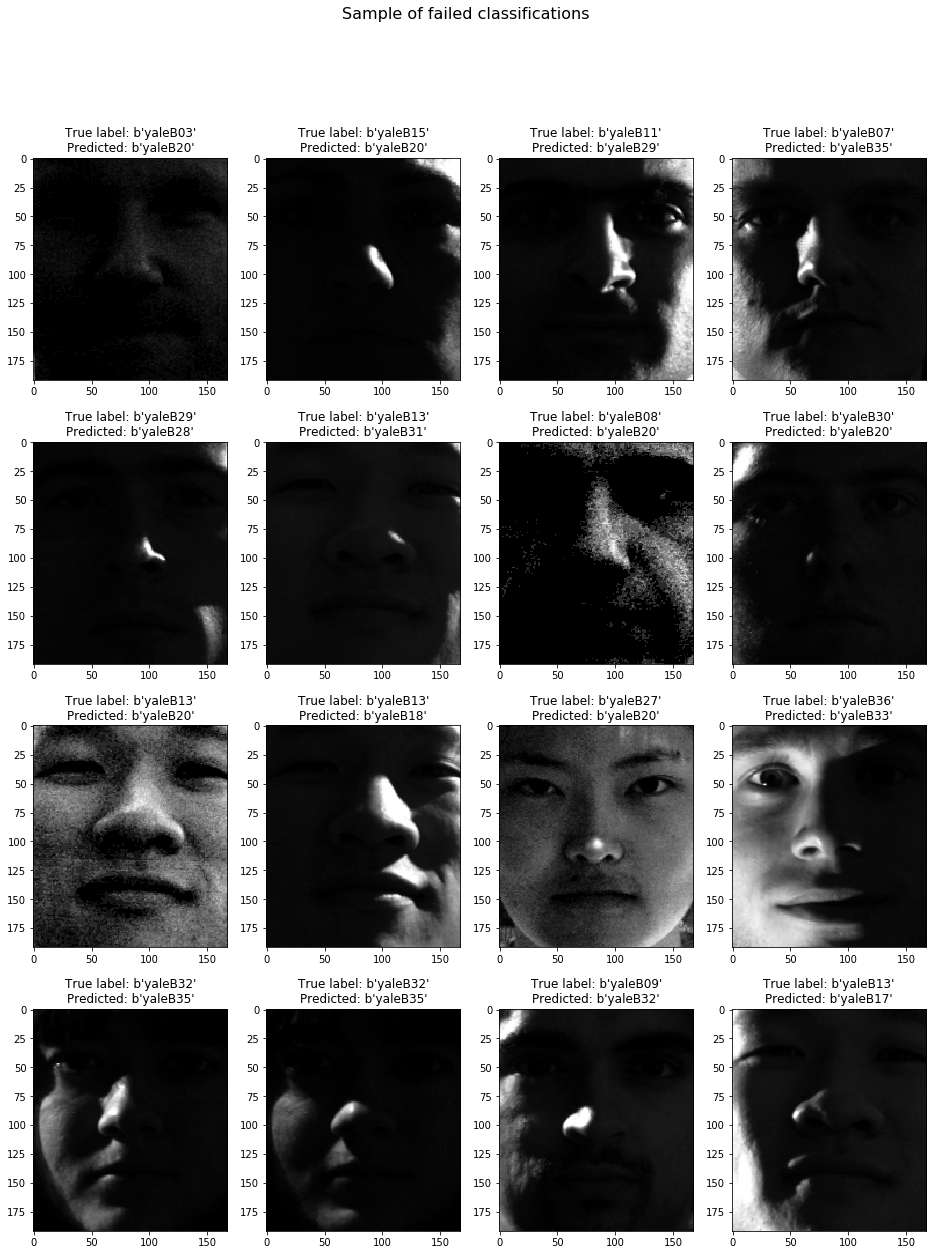

In [196]:
# show a number of failed classifications

# decode class label names from predicted and true encoded classes
true_classes = encoder.inverse_transform(y)
pred_classes = encoder.inverse_transform(y_pred)


ROWS, COLS = 4, 4
# choose a number of random failed classifications
error_index = np.random.choice(np.argwhere(y_pred != y).ravel(), 
                               ROWS*COLS, replace=False)

fig, ax = plt.subplots(ncols=COLS, nrows=ROWS, figsize=(16, 20))

for ix, err_ix in enumerate(error_index):
    rix, cix = divmod(ix, COLS)
    
    true = true_classes[err_ix]
    pred = pred_classes[err_ix]
    title = 'True label: {}\nPredicted: {}'.format(true, pred)
    ax[rix, cix].set_title(title)
    
    image = X[err_ix].reshape(img_height, img_width)
    # plot image
    ax[rix, cix].imshow(image, cmap=plt.cm.Greys_r)
    
plt.suptitle('Sample of failed classifications', fontsize=16)
plt.savefig('report/wrong_predictions.png', bbox_inches='tight')
plt.show(block=True)